In [3]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from schwimmbad import JoblibPool

import reddemcee


rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
%matplotlib widget


# Data

In [4]:
ecc = pd.read_csv("ETP/eccentricity.csv")
prec = pd.read_csv("ETP/precession.csv")
obl = pd.read_csv("ETP/obliquity.csv")

ETP = np.zeros((4, 10001))
ETP[0] = ecc["x"]
ETP[1] = ecc["y"]
ETP[2] = obl["y"]
ETP[3] = prec["y"]

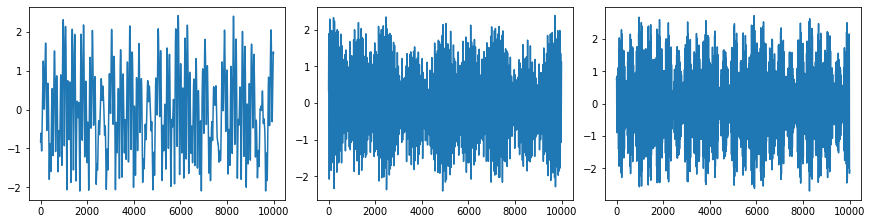

In [5]:
%matplotlib inline
fig, axs = plt.subplots(1,3,figsize=(12,3), constrained_layout=True)
axs[0].plot(ETP[0], ETP[1])
axs[1].plot(ETP[0], ETP[2])
axs[2].plot(ETP[0], ETP[3])

## Simulated data 
with age model and noise

In [196]:
i_t0 = 0; i_tf = 750
times = ETP[0,i_t0:i_tf]
alpha = 0.5
y_ecc = ETP[1,i_t0:i_tf]
y_prec = ETP[3,i_t0:i_tf]
a_e, a_p =  1, 1
y_model = (y_ecc*a_e+ y_prec*a_p)/ np.sqrt(a_e**2+a_p**2)
y_sp = CubicSpline(times, y_model)
depth = times*1 # 1 cm/1kyr average

# func_inv_SR = partial(sine_inverse_SR, A=0.3, k= 4*1e-3)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=50)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=2)
func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
times_true = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)


In [197]:
np.random.seed(3)

y_model = y_sp(times_true)
N_data = len(y_model)
sigma_true = .5
rho_true = 0.7

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise
y = y_model + noise
# y = abs(y)

Text(0, 0.5, 'time [kyr]')

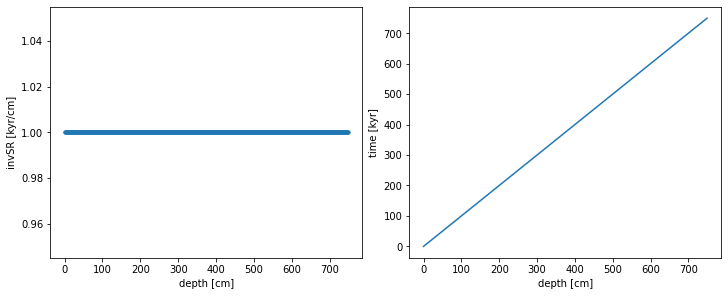

In [198]:
%matplotlib inline


plt.figure(constrained_layout=True,figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(depth, invSR, '.')
plt.xlabel("depth [cm]")
plt.ylabel("invSR [kyr/cm]")

plt.subplot(1,2,2)
plt.plot(depth, times_true)
plt.xlabel("depth [cm]")
plt.ylabel("time [kyr]")
# x = np.linspace(times[0],times[-1],1000000)
# y = sp(x)
# plt.plot(times,y_model,'.')
# plt.plot(x,y)


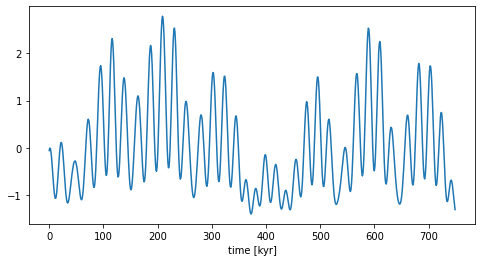

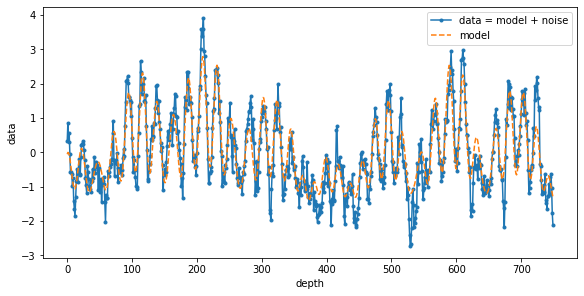

In [199]:

plt.figure(figsize=(8,4))
plt.plot(times_true, y_model)
plt.xlabel("time [kyr]")

plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(depth, y, '.-', label="data = model + noise")
plt.plot(depth, y_model,'--', label="model")
plt.xlabel("depth")
plt.ylabel("data")
plt.legend()

(0.0, 0.1)

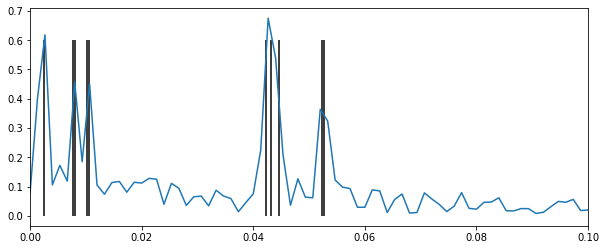

In [201]:
ydata_sp = CubicSpline(times_true, y)
times_grid = np.linspace(times_true[0], times_true[-1], len(times_true))
N = len(times_grid)
y_equ_spa = ydata_sp(times_grid)

dt = times_grid[1]-times_grid[0]
xf = sp.fft.fftfreq(N, dt)[:N//2]
yf = sp.fft.fft(y_equ_spa)

plt.figure(figsize=(10,4))

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.vlines(fs/2/np.pi, 0, 0.6, colors="black",alpha=1,zorder=-1)
plt.xlim([0,0.1])

# plt.plot(xf*2*np.pi, 2.0/N * np.abs(yf[0:N//2]))
# plt.vlines(fs, 0, 0.6, colors="black",alpha=1,zorder=-1)
# plt.xlim([0,0.5])

# plt.yscale("log")
# plt.xscale("log")
# plt.xlim([0.04,0.06])

# plt.vlines(fs[:5]/2/np.pi, 0, 0.6, colors="orange", alpha=0.8)
# plt.xlim([0.03,0.1])
# plt.xlim([0,0.025])
# plt.xlim([50,500])
# plt.xlim([10,50])

# Model

In [200]:
coef_time = 1e3
arcsec_to_pi = 1/180/3600*np.pi

b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
# p0 = 40
p0 = p0/180/3600*np.pi*coef_time

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
g_k = muy_k[ordering]
phi_k = phi_k[ordering]


# fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
# fe_k = fe_k/180/3600*np.pi*coef_time

fe_k =  np.array([g_k[1]-g_k[4], g_k[3]-g_k[4] , g_k[3]-g_k[1], g_k[2]-g_k[4], g_k[2]-g_k[1]])

fs = np.hstack([g_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

[0.27172399 0.28082533 0.32887003 0.33150547 0.26531565 0.01550968
 0.06618982 0.05068014 0.06355438 0.0480447 ]
[ 23.12341035  22.37399749  19.10537518  18.95348896  23.68192456
 405.11381166  94.92676503 123.97727122  98.86314252 130.7779167 ]


# Grid search

In [192]:
n, m = 50, 50
p0_grid = np.linspace(40,100,n)
p0_grid = p0_grid*1/180/3600*np.pi*coef_time
invSR_grid = np.linspace(0.01, 6, m)
p0_mg, invSR_mg = np.meshgrid(p0_grid, invSR_grid)

In [37]:
p0_grid

array([0.24240684, 0.24735392, 0.252301  , 0.25724808, 0.26219515,
       0.26714223, 0.27208931, 0.27703639, 0.28198347, 0.28693055,
       0.29187762, 0.2968247 , 0.30177178, 0.30671886, 0.31166594,
       0.31661302, 0.32156009, 0.32650717, 0.33145425, 0.33640133,
       0.34134841, 0.34629549, 0.35124256, 0.35618964, 0.36113672,
       0.3660838 , 0.37103088, 0.37597796, 0.38092504, 0.38587211,
       0.39081919, 0.39576627, 0.40071335, 0.40566043, 0.41060751,
       0.41555458, 0.42050166, 0.42544874, 0.43039582, 0.4353429 ,
       0.44028998, 0.44523705, 0.45018413, 0.45513121, 0.46007829,
       0.46502537, 0.46997245, 0.47491952, 0.4798666 , 0.48481368])

In [202]:
r2_grid = np.zeros((m, n))
r2_env_grid = np.zeros((m, n))
for i in range(n):
    for j in range(m):
        p0_i, invSR_i = p0_mg[j,i] , invSR_mg[j,i]
        reg = linear_model.LinearRegression()
        fs = np.hstack([g_k + p0_i, fe_k])
        invSR = np.ones_like(depth)*invSR_i
        timesx = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)
        dt = timesx[1]-timesx[0]
        X = generate_X_linReg(np.ones_like(fs), fs, timesx)
        reg.fit(X, y)
        y_pred = reg.predict(X)
        r2_grid[j,i] = r2_score(y, y_pred)
        f_sampling = 1/dt
        if p0_i/2/np.pi >= 1/dt/2:
            window_filter = [2*f_sampling/2 - p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, f_sampling/2-0.01)]
            # print(window_filter)
        else:
            window_filter = [p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, f_sampling/2-0.01)]
            # continue
        # window_filter = [p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, 1/dt/2-0.1)]
        sos = sp.signal.butter(10, window_filter, 'bandpass', output='sos' , fs=f_sampling)
        y_filtered = sp.signal.sosfiltfilt(sos, y)
        complex_y = sp.signal.hilbert(y_filtered)
        y_envelope = abs(complex_y)
        y_envelope = (y_envelope-y_envelope.mean())/y_envelope.std()
        X = generate_X_linReg(np.ones_like(fe_k), fe_k, timesx)
        reg.fit(X, y_envelope)
        y_env_pred = reg.predict(X)
        r2_env_grid[j,i] = r2_score(y_envelope, y_env_pred)
        
        
# print(r2_score(y_model, y_pred))
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_
i_best, j_best = np.where(r2_grid==r2_grid.max())
invSR_grid[i_best], p0_grid[j_best]
print(r2_grid.max()), print(r2_env_grid.max())

0.7913447030623407
0.9999082449815269


(None, None)

In [209]:
r2_grid = np.zeros((m, n))
r2_env_grid = np.zeros((m, n))
for i in range(n):
    for j in range(m):
        p0_i, invSR_i = p0_mg[j,i] , invSR_mg[j,i]
        reg = linear_model.LinearRegression()
        fs = np.hstack([g_k + p0_i, fe_k])
        invSR = np.ones_like(depth)*invSR_i
        timesx = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)
        dt = timesx[1]-timesx[0]
        f_sampling = 1/dt

        if (p0_i+g_k[3])/2/np.pi >= f_sampling/2:
            # print("aa")
            continue 
        
        
        X = generate_X_linReg(np.ones_like(fs), fs, timesx)
        reg.fit(X, y)
        y_pred = reg.predict(X)
        r2_grid[j,i] = r2_score(y, y_pred)
  
            # print(window_filter)
        # else:
        window_filter = [p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, f_sampling/2-0.01)]
            # continue
        # window_filter = [p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, 1/dt/2-0.1)]
        sos = sp.signal.butter(10, window_filter, 'bandpass', output='sos' , fs=f_sampling)
        y_filtered = sp.signal.sosfiltfilt(sos, y)
        complex_y = sp.signal.hilbert(y_filtered)
        y_envelope = abs(complex_y)
        y_envelope = (y_envelope-y_envelope.mean())/y_envelope.std()
        X = generate_X_linReg(np.ones_like(fe_k), fe_k, timesx)
        reg.fit(X, y_envelope)
        y_env_pred = reg.predict(X)
        r2_env_grid[j,i] = r2_score(y_envelope, y_env_pred)
        
        
# print(r2_score(y_model, y_pred))
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_
i_best, j_best = np.where(r2_grid==r2_grid.max())
invSR_grid[i_best], p0_grid[j_best]
print(r2_grid.max()), print(r2_env_grid.max())

aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
aa
0.7913447030623407
0.9999082449815269


(None, None)

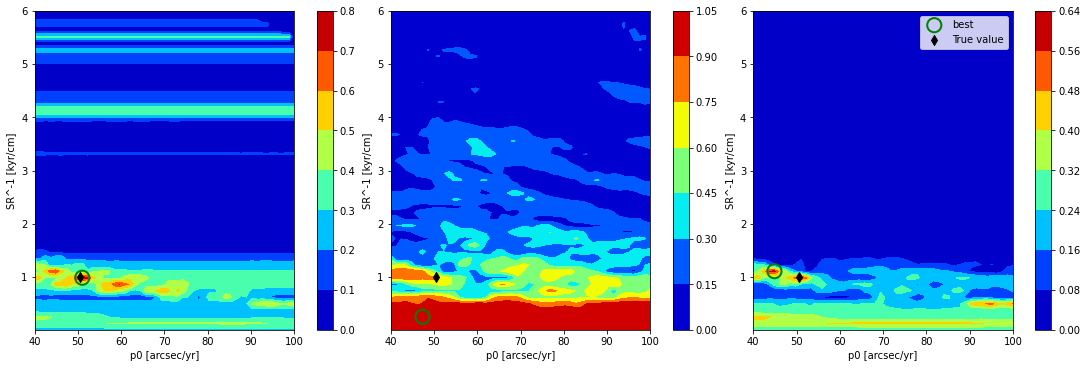

In [210]:
from matplotlib.patches import Rectangle
# plt.figure(figsize=(15,10))
fig, axs = plt.subplots(1, 3, figsize=(15,5),constrained_layout=True)
r2_comp = r2_grid*r2_env_grid
r2s = r2_grid, r2_env_grid, r2_comp

for i in range(3):
    ax = axs[i]
    i_best, j_best = np.where(r2s[i]==r2s[i].max())
    # print(r2_grid.max()), print(r2_env_grid.max())
    a = ax.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2s[i], cmap=plt.cm.jet)
    # plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_env_grid, cmap=plt.cm.jet, vmin=0,vmax=r2_env_grid.max())

    plt.colorbar(a)
    ax.scatter(p0_grid[j_best]/(1/180/3600*np.pi*coef_time), invSR_grid[i_best], s=200, color="green", label="best",facecolors='none',linewidths=2)
    # ax.scatter(85.8, 1/3.5, marker="d", s=50, color="k",label="Meyer's value")
    ax.scatter(50.467718, 1, marker="d", s=50, color="k",label="True value")
    # plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
    # plt.xlabel("")
    # rect = Rectangle((78-14,0.2),14*2,0.2,linewidth=2,edgecolor='k',facecolor='none', label="Meyer's range")
    # ax.add_patch(rect)
    # ax.set_ylim([0.1,2])
    ax.set_xlabel("p0 [arcsec/yr]")
    ax.set_ylabel("SR^-1 [kyr/cm]")
plt.legend()
# plt.ax
# plt.contour(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
# plt.axis('scaled')
# plt.savefig("Xiamaling/constantSR.png",dpi=300)

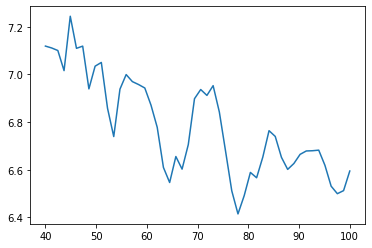

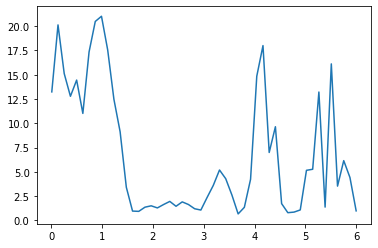

In [204]:
plt.plot(p0_grid/(1/180/3600*np.pi*coef_time), r2_grid.sum(axis=0))
plt.figure()
plt.plot(invSR_grid, r2_grid.sum(axis=1))